# Here you need to add the paper title, and then a small block of general explanation for a binder

# Experiments on neuromuscular efficiency of respiratory muscles

Import libraries

In [1]:
import copy
import math
import collections
from scipy import interpolate as interp
import scipy
import pandas as pd
import glob
import os
import sys
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime
%matplotlib widget

# The cell below will need to be changed for a generalized binder

In [2]:
sys.path.insert(0, '../ReSurfEMG')
import helper_functions as hf
from config import Config
config = Config()

In [3]:
# get new changes in our library i.e. the tmsisdk
import sys
sys.path.insert(0, '../resurfemg')

from tmsisdk_lite import Poly5Reader

# Initiation of output folder for experiments

In [4]:
# Output data - General path to dir for saving .csvs and plots
main_output_dir = config.get_directory('preprocessed') + \
                    '/2023_09_19_augmented_baseline'
if not os.path.exists(main_output_dir):
    os.makedirs(main_output_dir)

The below cell allows you to pick whether to display and interact with the data in seconds or samples.

In [5]:
y_axis = widgets.Dropdown(
    options=["Samples", "Seconds"],
    value='Seconds',
    description="Select View Option",
    disabled=False,
)
display(y_axis)

Dropdown(description='Select View Option', index=1, options=('Samples', 'Seconds'), value='Seconds')

The below cell confirms your choice.

In [6]:
time_view = y_axis.value
time_view

'Seconds'

<a id='#patient_select'>Input patient file path</a>

In [7]:
# Root directory for patient data
root_patient_data_directory = \
    config.get_directory('root_patient_data_directory')

patient_idx = 0
measurements = []

# Patient data selection

In [8]:
# Reruns should be done from this cell as the start

<a id='section_patient_step'>Next patient</a>

In [417]:
patient_folders = \
    glob.glob(root_patient_data_directory + '/**/', recursive=False)
patients = []
prev_measurements = measurements

for folder in patient_folders:
    name = folder.split("\\")[-2]
    patients.append(name)

btn_pt = widgets.Dropdown(  
    options=patients,
    value=patients[patient_idx],
    description='Select patient:',
    disabled=False,
)

date_idx = 0

display(btn_pt)

Dropdown(description='Select patient:', index=9, options=('MST001', 'MST002', 'MST003', 'MST004', 'MST005', 'M…

<a id='section_date_step'>Next date</a>

In [418]:
patient = btn_pt.value
patient_idx =btn_pt.index

measurement_folders = glob.glob(root_patient_data_directory 
                                + '/' + patient 
                                + '/**/',
                                recursive=False
                                )
measurements = []

for folder in measurement_folders:
    name = folder.split("\\")[-2]
    measurements.append(name)

btn_measurement = widgets.Dropdown(
    options=measurements,
    value=measurements[date_idx],
    description='Select measurement date:',
    disabled=False,
)
display(btn_measurement)

Dropdown(description='Select measurement date:', options=('2022-04-25_09-36-15', '2022-04-29_09-36-07'), value…

In [419]:
gate_width = 0.1
gate_twice = False

if (date_idx == 0) & ((patient_idx == 0) | len(prev_measurements) == 0):
    pass
elif (date_idx == 0) & (patient_idx > 0):
    if not os.path.exists(main_output_dir + '/' + patients[patient_idx-1] 
                          + '/' + prev_measurements[-1]  + '/' 
                          + prev_measurements[-1] + '_' 
                          + patients[patient_idx-1] 
                          +'_NME_output_gate_'
                          + str(int(gate_width*1000))+'.csv'):
        print(patients[patient_idx-1], prev_measurements[-1])
        print('Warning: Data of previous patient not stored! '
              +'Do not progress to next patient!')
    else:
        print(patients[patient_idx-1], prev_measurements[-1])
        print('Notification: Data stored appropriately! '
              +'You can progress to the selected date of the new patient!')
else:    
    if not os.path.exists(main_output_dir + '/' + patient + '/' 
                          + measurements[date_idx-1]  + '/' 
                          + measurements[date_idx-1] + '_' + patient 
                          + '_NME_output_gate_'
                          + str(int(gate_width*1000))+'.csv'):
        print(measurements[date_idx-1])
        print('Warning: Data of previous date not stored! '
              +'Do not progress to next date!')
    else:
        print(measurements[date_idx-1])
        print('Notification: Data of previous date stored appropriately! '
              +'You can progress to selected date!')
        


MST009 2022-04-29_09-36-07


In [420]:
# Rerun for each new measurement DAY (empty output parameter list)!
measurement = btn_measurement.value
date_idx = btn_measurement.index

# Input data
windows_str = root_patient_data_directory + '/' + patient + '/' + measurement
root_emg_directory = os.path.join(windows_str)

# do not rerun this cell
big_data_list = []
ecg_data_list = []


measurement_idx = -4

<a id='section_peep_step'>Next PEEP step</a>

Now you can pick a file from the list, which have been numbered.

In [603]:
# Select measurement number
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)
list_of_numbers_strung = []

for i in range(len(emg_files)):
    # list_of_numbers_strung.append(str(i))

    list_of_numbers_strung.append(emg_files[i].split('\\')[-2])


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value=str(emg_files[measurement_idx].split('\\')[-2]),
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', index=8, options=('001', '002', '003', '004', '005', '006', '007', '008',…

In [604]:
number_chosen = int(btn.index)
measurement_idx = int(btn.index)
emg_file_chosen = emg_files[number_chosen]
draeger_file_chosen = draeger_files[number_chosen]
print("The files you chose are:\n", emg_file_chosen, '\n', draeger_file_chosen)

The files you chose are:
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST010/2022-04-25_09-36-15\009\EMG_recording.Poly5 
 P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST010/2022-04-25_09-36-15\009\Draeger_recording.Poly5


In [605]:
# get the poly5 reading
data_emg = Poly5Reader(emg_file_chosen)
data_draeger = Poly5Reader(draeger_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
emg_sample_rate = data_emg.sample_rate
data_draeger_samples = data_draeger.samples[:data_draeger.num_samples]
draeger_sample_rate = data_draeger.sample_rate

# Output data path - Patient specific
patient = emg_files[number_chosen].split('\\')[-3].split('/')[-2]
measurement = emg_files[number_chosen].split('\\')[-2]

if not os.path.exists(main_output_dir + '/' + patient + '/'):
    os.makedirs(main_output_dir + '/' + patient + '/')

if not os.path.exists(main_output_dir + '/' + patient 
                      + '/' + measurements[date_idx] + '/'
):
    os.makedirs(main_output_dir + '/' + patient + '/' 
                + measurements[date_idx] + '/')

Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST010/2022-04-25_09-36-15\009\EMG_recording.Poly5
	 Number of samples:  734784 
	 Number of channels:  3 
	 Sample rate: 2048 Hz


Done reading data.
Reading file  P:/TNW/CRPH/Projects/2021_Warnaar_TOPSPIN_studie/4_Patient_data/1_RAW/MST010/2022-04-25_09-36-15\009\Draeger_recording.Poly5
	 Number of samples:  35874 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [606]:
x_emg = data_emg_samples
x_draeger = data_draeger_samples

y_emg = [i/emg_sample_rate for i in range(len(x_emg[0, :]))]
y_draeger = [i/draeger_sample_rate for i in range(len(x_draeger[0, :]))]

In [607]:
# Load settings from prior run
readme_file_name_prev = config.get_directory('preprocessed') \
                        + '/2023_09_15_PTP_peak_occlusion/' \
                        + patient + '/' + measurements[date_idx] + '/' \
                        + measurements[date_idx] + '_' + patient + '_' \
                        + measurement + '_readme.txt'

if not os.path.exists(readme_file_name_prev):
    readme_file_name_prev = config.get_directory('preprocessed') \
                            + '/2023_07_07_Set_Quality_criteria/' + patient + '/' \
                            + measurements[date_idx] + '/' \
                            + measurements[date_idx] + '_' + patient + '_' \
                            + measurement + '_readme.txt'

try:
    with open(readme_file_name_prev, 'r') as f:
        readme_str = f.read()
        
        settings_lines = readme_str.split('\n')
        
        
        t_start_prev = float(settings_lines[1].split(' ')[-2])
        t_end_prev = float(settings_lines[2].split(' ')[-2])

        gate_width_prev = float(settings_lines[3].split(' ')[-2])/1000
        gate_threshold_prev = float(settings_lines[4].split(' ')[-1])
        gate_ECG_shift_prev = int(settings_lines[5].split(' ')[-2])
        
        time_shift_prev = float(settings_lines[6].split(' ')[-2])

        Pocc_prominence_factor_prev = float(settings_lines[7].split(' ')[-1])
        EMG_di_prominence_factor_prev = float(settings_lines[8].split(' ')[-1])
        EMG_para_prominence_factor_prev = float(
            settings_lines[9].split(' ')[-1])

        if len(settings_lines) > 12:
            N_gated = int(settings_lines[11].split(' ')[-1])
            if N_gated == 2:
                gate_twice = True
            

        print(readme_str + '\n')
    f.close()
    prev_settings_loaded = True
except FileNotFoundError:
    print("Log file not found:")
    print(readme_file_name_prev)
    prev_settings_loaded = False
except ValueError:
    print("Error while reading log file!")
    prev_settings_loaded = False

if not prev_settings_loaded:
    t_start_prev = y_draeger[-1]-100
    t_end_prev = y_draeger[-1]-10

    gate_width_prev = 0.10
    gate_threshold_prev = 0.30
    gate_ECG_shift_prev = -10

    time_shift_prev = 0.5                   #Draeger delay
    Pocc_prominence_factor_prev = 0.8
    EMG_di_prominence_factor_prev = 0.01
    EMG_para_prominence_factor_prev = 0.01


MST010 / 2022-04-25_09-36-15 / 009
t_start: 320.0 s
t_end: 357.0 s
gate_width: 100 ms
gate_threshold: 0.3
gate_ECG_shift: -10 samples
time_shift: 0.5 s
Pocc_prominence_factor: 0.3
EMG_di_prominence_factor: 0.5
EMG_para_prominence_factor: 0.5
PEEP_set: 14.0
N_gated: 1
augmented_percentile: 40 %
analysis_date: 2023-09-18 11:29:27.087730



In [608]:
# If necessary: Plot data
if not prev_settings_loaded:
    fig, axis = plt.subplots(nrows=3, ncols=4, figsize=(10, 6))
    axis[0, 0].grid(True)
    axis[0, 0].plot(x_emg[0])
    axis[0, 0].set(title='EMG leads: samples')
    axis[1, 0].plot(x_emg[1])
    axis[2, 0].plot(x_emg[2])

    axis[0, 1].set(title='Draeger: samples')
    axis[0, 1].grid(True)
    axis[0, 1].plot(x_draeger[0])
    axis[1, 1].plot(x_draeger[1])
    axis[2, 1].plot(x_draeger[2])

    axis[0, 2].grid(True)
    axis[0, 2].plot(y_emg, x_emg[0])
    axis[0, 2].set(title='EMG leads: seconds')
    axis[1, 2].plot(y_emg, x_emg[1])
    axis[2, 2].plot(y_emg, x_emg[2])

    axis[0, 3].set(title='Draeger :seconds')
    axis[0, 3].grid(True)
    axis[0, 3].plot(y_draeger, x_draeger[0])
    axis[1, 3].plot(y_draeger, x_draeger[1])
    axis[2, 3].plot(y_draeger, x_draeger[2])

Here pick the part of the signal you want to look at. It is advised to never start at zero, or end after the signal, and the widgets have been constrained to do this.

In [609]:
start_widget = widgets.BoundedFloatText(
    value=np.floor(t_start_prev),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(t_end_prev),
    min=1,
    max=y_draeger[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])



In [610]:
start = start_widget.value  
end = end_widget.value  
if start >= end:    
    print('Please choose logical values. You made a mistake.')

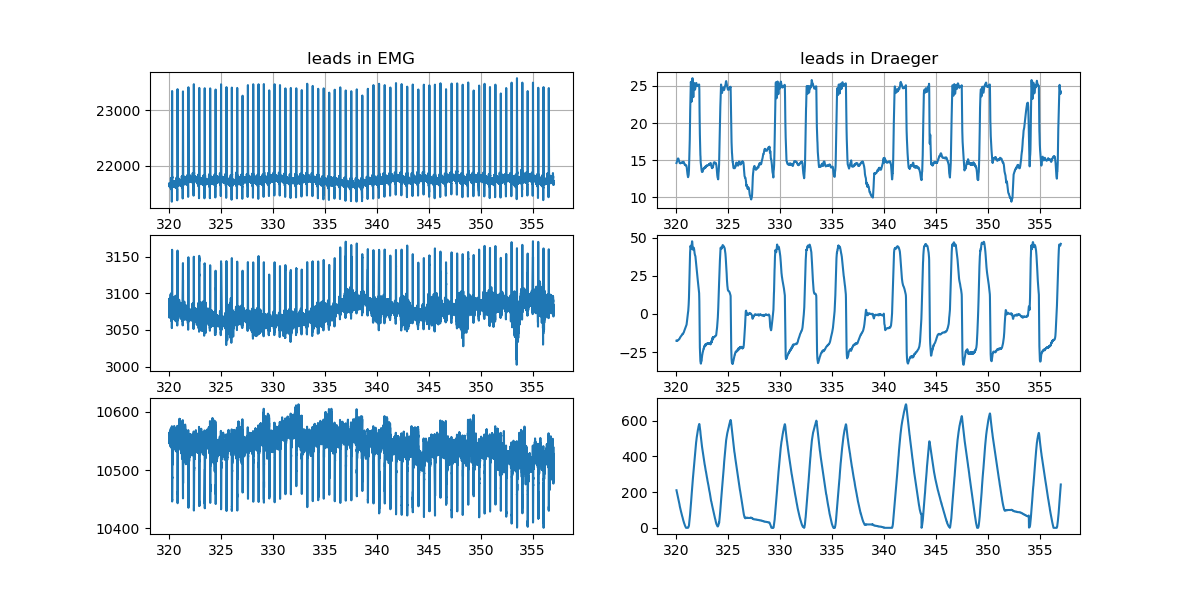

In [611]:
# now examine at the selected window to contain all occlusions

if time_view == 'Seconds':
    start_s = int(float(start)* emg_sample_rate)
    end_s = min([int(float(end)*emg_sample_rate), len(x_emg[0,:])-1])
    start_draeger_s = int(float(start)* draeger_sample_rate)
    end_draeger_s = min(
        [int(float(end)* draeger_sample_rate), len(x_draeger[0,:])-1]
    )

else:
    start_s = int(float(start))
    end_s = min([int(float(end)), len(data_emg_samples[0])-1])
    start_draeger_s = int(float(start)* draeger_sample_rate/emg_sample_rate)
    end_draeger_s = min(
        [int(float(start)* draeger_sample_rate/emg_sample_rate), 
         len(data_draeger_samples[0])-1]
    )
    y_emg = [range(len(data_emg_samples[0]))]
    y_draeger = [range(len(data_draeger_samples[0]))]


fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
axis[0, 0].set(title='leads in EMG')
axis[0, 0].grid(True)
axis[0, 0].plot(y_emg[int(start_s):int(end_s)], 
                x_emg[0][int(start_s):int(end_s)])
axis[1, 0].plot(y_emg[int(start_s):int(end_s)], 
                x_emg[1][int(start_s):int(end_s)])
axis[2, 0].plot(y_emg[int(start_s):int(end_s)], 
                x_emg[2][int(start_s):int(end_s)])

axis[0, 1].set(title='leads in Draeger')
axis[0, 1].grid(True)
axis[0, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[0][int(start_draeger_s):int(end_draeger_s)]
)
axis[1, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[1][int(start_draeger_s):int(end_draeger_s)]
)
axis[2, 1].plot(
    y_draeger[int(start_draeger_s):int(end_draeger_s)], 
    x_draeger[2][int(start_draeger_s):int(end_draeger_s)]
)

# Pre-processing

In [612]:
# Eliminate the baseline wander from the data
bd_filtered_file_data = hf.emg_bandpass_butter_sample(
    data_emg_samples, 1, 500, 2048, output='sos')
    
processed_data_emg_di = bd_filtered_file_data[1]
processed_data_emg_para = bd_filtered_file_data[2]

In [613]:
# Gating settings

# Window size to plot the gating results from
plot_window = 5         

# Peak height fraction
# peak_fraction = 0.30    
peak_fraction = gate_threshold_prev

# Shift of gated in samples relative to detected peaks
# ECG_shift = -10           
ECG_shift = gate_ECG_shift_prev

# Gate width in seconds
# gate_width = 0.1        
gate_width = gate_width_prev


# QRS peak detection settings
peak_width = 0.001
peak_dist = int(emg_sample_rate/3)


In [614]:
# Check number of gating iterations
if gate_twice == True:
    print('Signal will be gated TWICE!')
else:
    print('Signal will be gated ONCE!')

Signal will be gated ONCE!


In [615]:
# Apply QRS gating

# Detect ECG peaks on 1Hz high-pass filtered signals
ecg = bd_filtered_file_data[0]
ecg_rms = hf.full_rolling_rms(ecg, 10)
max_ecg_rms = max(
    ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
min_ecg_rms = min(
    ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

ECG_peaks, properties  = scipy.signal.find_peaks(
    ecg_rms, 
    height=peak_height, 
    width=peak_width*emg_sample_rate, 
    distance=peak_dist
)
ECG_peaks = ECG_peaks - ECG_shift

# Filter EXG signals 20Hz high pass
ECG_h20 = hf.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
emg_di_h20 = hf.emg_bandpass_butter_sample(
    processed_data_emg_di, 20, 500, 2048, output='sos')
emg_para_h20 = hf.emg_bandpass_butter_sample(
    processed_data_emg_para, 20, 500, 2048, output='sos')

# Gate ECG and EMG signal
# Fill methods 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# 3: Moving average
gate_fill_method = 3    
gate_width_samples = int(gate_width*emg_sample_rate)

gate_samples = list()
for i in range(len(ECG_peaks)):
    for k in range(
        int(ECG_peaks[i]-gate_width_samples/2),
        int(ECG_peaks[i]+gate_width_samples/2)
    ):
        gate_samples.append(k)

ECG_gated = hf.gating(
    ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_di_gated = hf.gating(
    emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
emg_para_gated = hf.gating(
    emg_para_h20, ECG_peaks, gate_width=gate_width_samples, method=3)


In [616]:
# Apply gating twice (in case of pacing)
if gate_twice == True:
    # Detect ECG peaks on 1Hz high-pass filtered signals
    ecg = ECG_gated
    ecg_rms = hf.full_rolling_rms(ecg, 10)
    max_ecg_rms = max(
        ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
    min_ecg_rms = min(
        ecg_rms[int(start_s):int(start_s+plot_window*emg_sample_rate)])
    peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

    ECG_peaks, properties  = scipy.signal.find_peaks(
        ecg_rms, 
        height=peak_height, 
        width=peak_width*emg_sample_rate, 
        distance=peak_dist
    )
    ECG_peaks = ECG_peaks - ECG_shift

    # # Filter EXG signals 20Hz high pass
    # ECG_h20 = hf.emg_bandpass_butter_sample(
    #     ECG_gated, 20, 500, 2048, output='sos')
    # emg_di_h20 = hf.emg_bandpass_butter_sample(
    #     emg_di_gated, 20, 500, 2048, output='sos')
    # emg_para_h20 = hf.emg_bandpass_butter_sample(
    #     emg_para_gated, 20, 500, 2048, output='sos')

    # Gate ECG and EMG signal
    # Fill methods: 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
    # 3: Moving average
    gate_fill_method = 3    
    gate_width_samples = int(gate_width*emg_sample_rate)

    gate_samples = list()
    for i in range(len(ECG_peaks)):
        for k in range(
            int(ECG_peaks[i]-gate_width_samples/2),
            int(ECG_peaks[i]+gate_width_samples/2)
        ):
            gate_samples.append(k)

    ECG_gated = hf.gating(
        ECG_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
    emg_di_gated = hf.gating(
        emg_di_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
    emg_para_gated = hf.gating(
        emg_para_gated, ECG_peaks, gate_width=gate_width_samples, method=3)


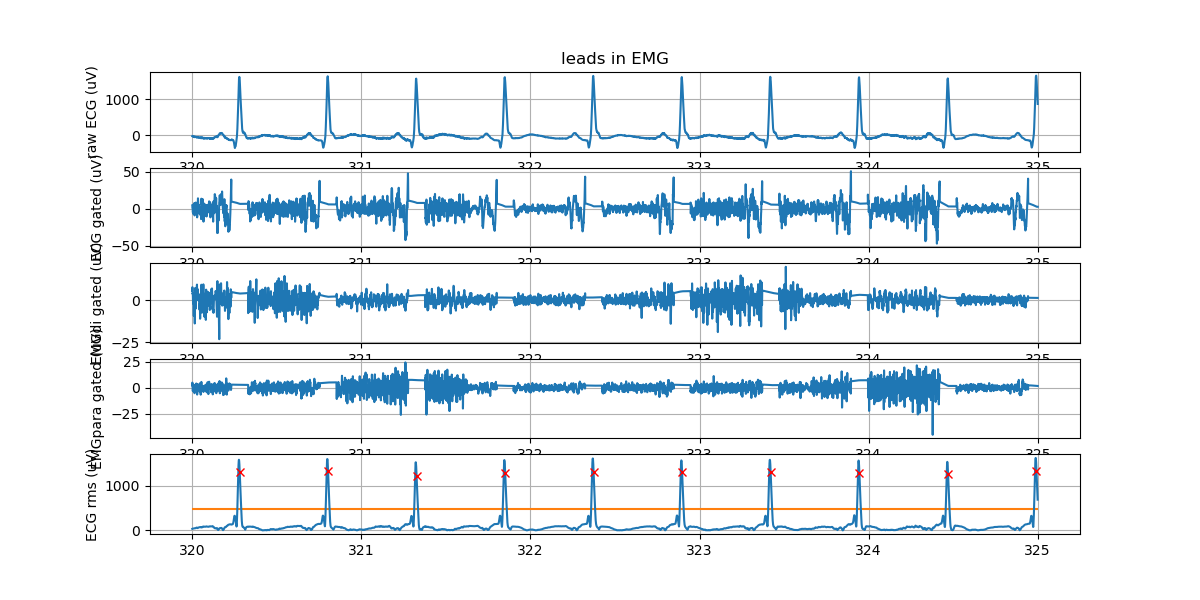

In [617]:
# Plot gating result

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
start_i = int(start_s)
end_i = int(start_s+plot_window*2048)
axis[0].grid(True)
axis[0].plot(y_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])
axis[0].set_ylabel('raw ECG (uV)')

axis[0].set(title='leads in EMG')
axis[1].grid(True)
axis[1].plot(y_emg[start_i:end_i], ECG_gated[start_i:end_i])
axis[1].set_ylabel('ECG gated (uV)')
axis[2].grid(True)
axis[2].plot(y_emg[start_i:end_i], emg_di_gated[start_i:end_i])
axis[2].set_ylabel('EMGdi gated (uV)')
axis[3].grid(True)
axis[3].plot(y_emg[start_i:end_i], emg_para_gated[start_i:end_i])
axis[3].set_ylabel('EMGpara gated (uV)')

axis[4].grid(True)
axis[4].plot(y_emg[start_i:end_i], ecg_rms[start_i:end_i])
axis[4].set_ylabel('ECG rms (uV)')
axis[4].hlines(
    y=peak_height, 
    xmin=y_emg[start_i], 
    xmax=y_emg[end_i],
    color = "C1"
)

for idx in range(len(ECG_peaks)):
    if ((ECG_peaks[idx] > int(start_s)) 
        & (ECG_peaks[idx] < int(start_s+plot_window*2048))):
        axis[4].plot(y_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


Calculate root mean squared (RMS)

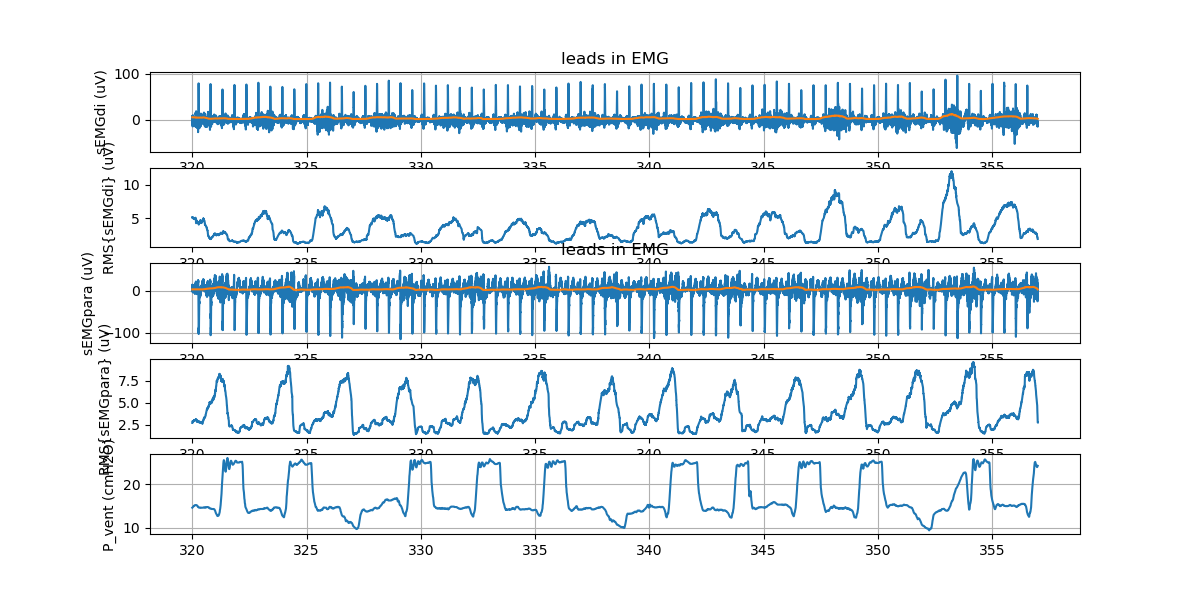

In [618]:
RMS_window_ms = 200
RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_sample_rate)

RMS_data_emg_di = hf.full_rolling_rms(emg_di_gated, RMS_windows_samp)
RMS_data_emg_para = hf.full_rolling_rms(emg_para_gated, RMS_windows_samp)

fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(12, 6))
axis[0].set(title='leads in EMG')
axis[0].set_ylabel('sEMGdi (uV)')
axis[0].grid(True)
axis[0].plot(y_emg[int(start_s):int(end_s)], 
             processed_data_emg_di[int(start_s):int(end_s)])

axis[0].plot(y_emg[int(start_s):int(end_s)], 
             RMS_data_emg_di[int(start_s):int(end_s)])

axis[1].set_xlabel('t (s)')
axis[1].set_ylabel('RMS{sEMGdi} (uV)')
axis[1].plot(y_emg[int(start_s):int(end_s)], 
             RMS_data_emg_di[int(start_s):int(end_s)])

axis[2].set(title='leads in EMG')
axis[2].set_ylabel('sEMGpara (uV)')
axis[2].grid(True)
axis[2].plot(y_emg[int(start_s):int(end_s)], 
             processed_data_emg_para[int(start_s):int(end_s)])
axis[2].plot(y_emg[int(start_s):int(end_s)], 
             RMS_data_emg_para[int(start_s):int(end_s)])

axis[3].set_xlabel('t (s)')
axis[3].set_ylabel('RMS{sEMGpara} (uV)')
axis[3].plot(y_emg[int(start_s):int(end_s)], 
             RMS_data_emg_para[int(start_s):int(end_s)])

axis[4].set_ylabel('P_vent (cmH2O)')
axis[4].grid(True)
axis[4].plot(y_draeger[int(start_draeger_s):int(end_draeger_s)], 
             x_draeger[0][int(start_draeger_s):int(end_draeger_s)])

# Feature extraction

In [619]:
x = x_draeger[2][:int(start_draeger_s)]
V_ee_PKS, _ = scipy.signal.find_peaks(-x)

PEEP_set = np.floor(np.median(x_draeger[0, V_ee_PKS]))


PEEP_set

14.0

In [620]:
# Extract ECG-amplitude (RMS)
ecg_data_list_new = np.column_stack(
    (np.matlib.repmat([patient, measurement, PEEP_set], len(ECG_peaks), 1), 
     ecg_rms[ECG_peaks + ECG_shift])
)


In [621]:
# Moving baseline QUICKer on pressure and all EMG signals for baseline crossing detection

baseline_W_emg = 5 * emg_sample_rate  # window length
baseline_W_draeger = 5 * draeger_sample_rate  # window length

# emg_di_rolling_base_line = np.percentile(strided_app(RMS_data_emg[int(start_s):int(end_s)], W,1), 33, axis=-1)
emg_di_rolling_base_line = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)]), ))
emg_para_rolling_base_line = np.zeros(
    (len(RMS_data_emg_para[int(start_s):int(end_s)]), ))
P_rolling_base_line = np.zeros(
    (len(x_draeger[0, int(start_draeger_s):int(end_draeger_s)]), ))

for idx in range(0, int(end_s)-int(start_s), int(emg_sample_rate/5)):
    start_i = max([int(start_s), int(start_s)+idx-int(baseline_W_emg/2)])
    end_i = min([int(end_s), int(start_s)+idx+int(baseline_W_emg/2)])
    baseline_value_emg_di = np.percentile(
        RMS_data_emg_di[start_i:end_i], 33)
    baseline_value_emg_para = np.percentile(
        RMS_data_emg_para[start_i:end_i], 33)
    for i in range(idx, 
                   min([idx+int(emg_sample_rate/5), int(end_s)-int(start_s)])
    ):
        emg_di_rolling_base_line[i] = baseline_value_emg_di
        emg_para_rolling_base_line[i] = baseline_value_emg_para

for idx in range(0, 
                 int(end_draeger_s)-int(start_draeger_s), 
                 int(draeger_sample_rate/5)
):
    start_i = max([int(start_draeger_s), int(
        start_draeger_s)+idx-int(baseline_W_draeger/2)])
    end_i = min([int(end_draeger_s), int(start_draeger_s) +
                idx+int(baseline_W_draeger/2)])
    P_rolling_base_line[idx] = np.percentile(x_draeger[0, start_i:end_i], 33)

    baseline_value_P = np.percentile(x_draeger[0, start_i:end_i], 33)
    for i in range(idx, 
            min([idx+int(draeger_sample_rate/5), 
                 int(end_draeger_s)-int(start_draeger_s)])
    ):
        P_rolling_base_line[i] = baseline_value_P

Get PTPocc

In [624]:
Pocc_prominence_factor = 0.3
# Pocc_prominence_factor = Pocc_prominence_factor_prev

Pocc_prominence_factor

0.15

In [625]:
# Detect (negative) occlussion peaks in pressure signal

treshold = 0
width = int(0.1 * draeger_sample_rate)
prominence = Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0]))
height = -(PEEP_set - Pocc_prominence_factor *np.abs( PEEP_set - min(x_draeger[0])))
distance = int(0.5 * draeger_sample_rate)

x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]
P_occ_peaks, properties  = scipy.signal.find_peaks(
    -x, 
    height=height, 
    prominence=prominence, 
    width=width, 
    distance=distance
)
# x = x_draeger[0, int(start_draeger_s):int(end_draeger_s)]

PEEP_crossings_idx = np.argwhere(np.diff(np.sign(x - P_rolling_base_line)) != 0)

P_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
P_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    PEEP_crossings_idx_sub = np.sign(x[:P_occ_peaks[idx]] - P_rolling_base_line[:P_occ_peaks[idx]])
    a = np.argmin(P_occ_peaks[idx] - np.argwhere(np.diff(PEEP_crossings_idx_sub) != 0))
    P_occ_starts[idx] = int(PEEP_crossings_idx[a])
    P_occ_ends[idx] = int(PEEP_crossings_idx[a+1])

P_occ_starts,P_occ_peaks,  P_occ_ends, prominence, height

(array([ 648, 1808, 3152]),
 array([ 719, 1889, 3224], dtype=int64),
 array([ 745, 1945, 3310]),
 2.1,
 -11.9)

In [626]:
# Data sanity check: check to make sure your data has an occlusion even
if len(P_occ_starts) == 0 or len(P_occ_peaks) ==0  or len(P_occ_ends) == 0:
    print('You have chosen something without the proper sort of occlusion peak,' 
          + 'please examine data')
else:
    print('You may continue!')

You may continue!


EMG peak identification

In [627]:
EMG_di_prominence_factor_prev, EMG_para_prominence_factor_prev

(0.5, 0.5)

In [628]:
# EMG peak detection parameters:

# Threshold peak height as fraction of max peak height 
EMG_di_prominence_factor = 0.5         
# EMG_di_prominence_factor = EMG_di_prominence_factor_prev

# Threshold peak height as fraction of max peak height
EMG_para_prominence_factor = 0.5       
# EMG_para_prominence_factor = EMG_para_prominence_factor_prev

# Draeger delay
# draeger_delay = 0.5
draeger_delay = time_shift_prev = 0.5                   

emg_peak_width = 0.2
percentile_border = 90

In [629]:
# Augmented signal EMG + abs(dEMG/dt)
ma_window = window=emg_sample_rate//2
augmented_perc = 25
perc_window = emg_sample_rate

y_di = RMS_data_emg_di[int(start_s):int(end_s)]
s_di = pd.Series(y_di - emg_di_rolling_base_line)
EMG_di_MA = s_di.rolling(window=ma_window, center=True).mean().values
dEMG_di_dt = (EMG_di_MA[1:] - EMG_di_MA[:-1] ) * emg_sample_rate
EMG_di_aug = y_di[:-1] + np.abs(dEMG_di_dt)

y_para = RMS_data_emg_para[int(start_s):int(end_s)]
s_para = pd.Series(y_para - emg_para_rolling_base_line)
EMG_para_MA = s_para.rolling(window=ma_window, center=True).mean().values
dEMG_para_dt = (EMG_para_MA[1:] - EMG_para_MA[:-1] ) * emg_sample_rate
EMG_para_aug = y_para[:-1] + np.abs(dEMG_para_dt)

# Rolling baseline of augmented signals
emg_di_aug_rolling_base_line = np.zeros(
    (len(RMS_data_emg_di[int(start_s):int(end_s)-1]), ))
emg_para_aug_rolling_base_line = np.zeros(
    (len(RMS_data_emg_para[int(start_s):int(end_s)-1]), ))

for idx in range(0, int(end_s-1)-int(start_s), perc_window):
    start_i = max([0, idx-int(baseline_W_emg)])
    end_i = min([int(end_s-start_s-1), idx+int(baseline_W_emg)])

    baseline_value_emg_di = np.nanpercentile(
        EMG_di_aug[start_i:end_i], augmented_perc)

    baseline_value_emg_para = np.nanpercentile(
        EMG_para_aug[start_i:end_i], augmented_perc)
    
    for i in range(idx, 
                   min([idx+int(perc_window), int(end_s-1)-int(start_s)])
    ):
        emg_di_aug_rolling_base_line[i] = 1.2 * baseline_value_emg_di
        emg_para_aug_rolling_base_line[i] = 1.2 * baseline_value_emg_para

In [630]:
# Find diaphragmatic EMG peaks

y_di = RMS_data_emg_di[int(start_s):int(end_s)]
treshold = 0
width = int(emg_peak_width * emg_sample_rate)
prominence = EMG_di_prominence_factor * \
    (np.nanpercentile(y_di - emg_di_rolling_base_line, 75) 
     + np.nanpercentile(y_di - emg_di_rolling_base_line, 50))
    # np.std((y_di - emg_di_rolling_base_line))
    # np.percentile(y_di - emg_di_rolling_base_line, percentile_border)
EMG_peaks_di, properties = scipy.signal.find_peaks(
    y_di, height=treshold, prominence=prominence, width=width)

# Link EMG peak closest to occlusion pressures
EMG_di_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_di + draeger_delay * emg_sample_rate 
               - P_occ_peak_converted)
    )

    EMG_di_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

# Old method
baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_di - emg_di_rolling_base_line)) != 0)

EMG_di_occ_starts_old = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_di_occ_ends_old = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_di[:EMG_di_occ_peaks[idx]] 
        - emg_di_rolling_base_line[:EMG_di_occ_peaks[idx]]
    )
    a = np.argmin(
        EMG_di_occ_peaks[idx] 
        - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    
    EMG_di_occ_starts_old[idx] = int(baseline_crossings_idx[a])
    
    if a < len(baseline_crossings_idx) - 1:
        EMG_di_occ_ends_old[idx] = int(baseline_crossings_idx[a+1])
    else:
        EMG_di_occ_ends_old[idx] = len(y_di) - 1 

# New method
baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(EMG_di_aug - emg_di_aug_rolling_base_line)) != 0)

EMG_di_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_di_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        EMG_di_aug[:EMG_di_occ_peaks[idx] - ma_window//2] 
        - emg_di_aug_rolling_base_line[:EMG_di_occ_peaks[idx] - ma_window//2]
    )
    a = np.argmin(
        EMG_di_occ_peaks[idx] 
        - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    
    EMG_di_occ_starts[idx] = int(baseline_crossings_idx[a]) + ma_window*2//5 
    
    
    if a < len(baseline_crossings_idx) - 1:
        EMG_di_occ_ends[idx] = min(
            baseline_crossings_idx[
                baseline_crossings_idx > (EMG_di_occ_peaks[idx] + ma_window//2)
                ]) - ma_window*2//5
        # EMG_di_occ_ends[idx] = int(baseline_crossings_idx[a+1]) - ma_window*2//5
    else:
        EMG_di_occ_ends[idx] = len(y_di) - 1 

EMG_di_occ_starts_old, EMG_di_occ_starts, EMG_di_occ_peaks, EMG_di_occ_ends_old, EMG_di_occ_ends

(array([12984, 36900, 64502]),
 array([13720, 37176, 65133]),
 array([13854, 37309, 65276]),
 array([14249, 37718, 65710]),
 array([14158, 37414, 65613]))

In [631]:
# Find parasternal EMG peaks

y_para = RMS_data_emg_para[int(start_s):int(end_s)]
treshold = 0
width = int(emg_peak_width * emg_sample_rate)
prominence = EMG_para_prominence_factor * \
    (np.nanpercentile(y_para - emg_para_rolling_base_line, 75) 
     + np.nanpercentile(y_para - emg_para_rolling_base_line, 50))
    # np.std((y_para - emg_para_rolling_base_line))
    # np.percentile(y_para - emg_para_rolling_base_line, percentile_border)

EMG_peaks_para, properties = scipy.signal.find_peaks(
    y_para, height=treshold, prominence=prominence, width=width)

# Link EMG peak closest to occlusion pressures
EMG_para_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    P_occ_peak_converted = P_occ_peaks[idx]/draeger_sample_rate*emg_sample_rate
    PKS_idx[idx] = np.argmin(
        np.abs(EMG_peaks_para + draeger_delay * emg_sample_rate 
               - P_occ_peak_converted))
    EMG_para_occ_peaks[idx] = EMG_peaks_para[PKS_idx[idx]]

# Old method
baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(y_para - emg_para_rolling_base_line)) != 0)

EMG_para_occ_starts_old = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_para_occ_ends_old = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        y_para[:EMG_para_occ_peaks[idx]] 
        - emg_para_rolling_base_line[:EMG_para_occ_peaks[idx]])
    a = np.argmin(
        EMG_para_occ_peaks[idx] 
        - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    EMG_para_occ_starts_old[idx] = int(baseline_crossings_idx[a])
    if a < len(baseline_crossings_idx) - 1:
        EMG_para_occ_ends_old[idx] = int(baseline_crossings_idx[a+1])
    else:
        EMG_para_occ_ends_old[idx] = len(y_para) - 1 

# New method
baseline_crossings_idx = np.argwhere(
    np.diff(np.sign(EMG_para_aug - emg_para_aug_rolling_base_line)) != 0)

EMG_para_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
EMG_para_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    baseline_crossings_idx_sub = np.sign(
        EMG_para_aug[:EMG_para_occ_peaks[idx] - ma_window//2] 
        - emg_para_aug_rolling_base_line[:EMG_para_occ_peaks[idx] - ma_window//2]
    )
    a = np.argmin(
        EMG_para_occ_peaks[idx] 
        - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    
    EMG_para_occ_starts[idx] = int(baseline_crossings_idx[a]) + ma_window*2//5 
    
    if a < len(baseline_crossings_idx) - 1:
        EMG_para_occ_ends[idx] = min(
            baseline_crossings_idx[
                baseline_crossings_idx > (EMG_para_occ_peaks[idx] + ma_window//2)
                ]) - ma_window*2//5
        # EMG_para_occ_ends[idx] = int(baseline_crossings_idx[a+1]) - ma_window*2//5
    else:
        EMG_para_occ_ends[idx] = len(y_para) - 1 

EMG_para_occ_starts_old, EMG_para_occ_starts, EMG_para_occ_ends_old, EMG_para_occ_ends

(array([10819, 36296, 63579]),
 array([12168, 36342, 63801]),
 array([14361, 38333, 65766]),
 array([14441, 38442, 65859]))

(array([13720, 37176, 65133]),
 array([12984, 36900, 64502]),
 array([14158, 37414, 65613]),
 array([14249, 37718, 65710]))

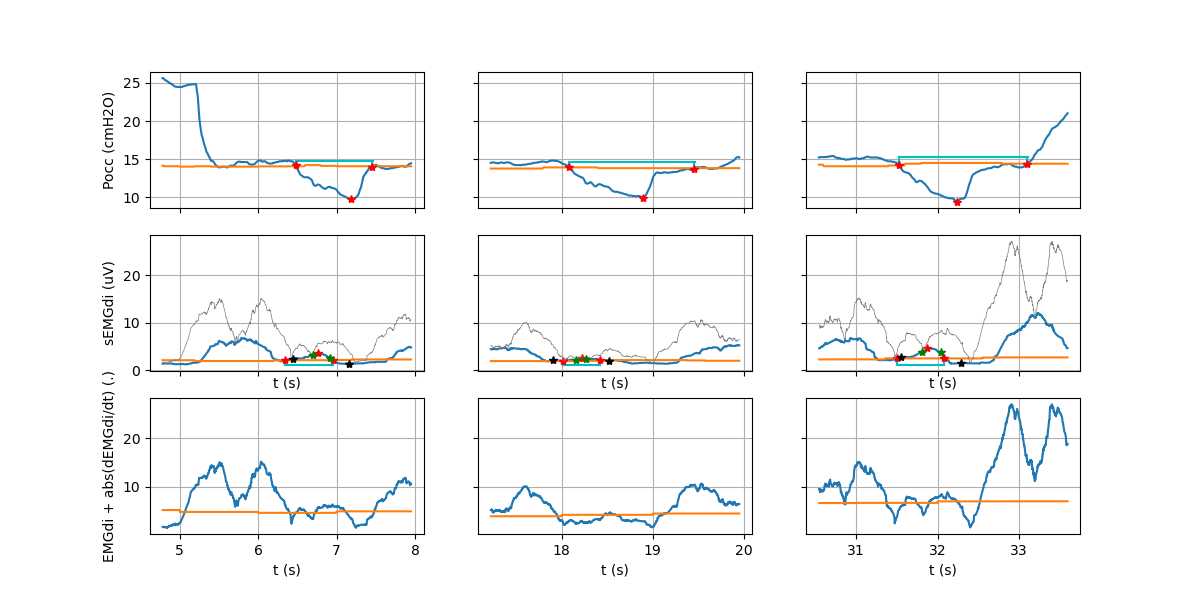

In [632]:
# Plot new baseline crossing detection diaphragm
fig_5, axis = plt.subplots(nrows=3, ncols=max([len(
    P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# Show EMG and Paw data for entire window
t_plot_start = np.min([[P_occ_starts / draeger_sample_rate], 
                    [EMG_di_occ_starts_old / emg_sample_rate], 
                    [EMG_para_occ_starts_old / emg_sample_rate]], axis=0)[0] - 0.5
t_plot_end = np.max([[P_occ_ends / draeger_sample_rate], 
                     [EMG_di_occ_ends_old / emg_sample_rate], 
                     [EMG_para_occ_ends_old / emg_sample_rate]], axis=0)[0] + 0.5


# PTP_occ_baseline[idx], ETP_di_baseline[idx], ETP_para_baseline[idx]]
PTP_occs = np.zeros((len(P_occ_peaks),))
P_aw_max = np.zeros((len(P_occ_peaks),))
PTP_occ_baseline = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * draeger_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * draeger_sample_rate), len(y_draeger)])

    axis[0, idx].grid(True)
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1], 
                      x[start_plot_i:end_plot_i+1])
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1],
                      P_rolling_base_line[start_plot_i:end_plot_i+1])    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*draeger_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*draeger_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    axis[0, idx].plot([y_draeger[start_i], y_draeger[end_i+1]], 
                      [P_aw_max[idx], P_aw_max[idx]], 'c')
    axis[0, idx].plot([y_draeger[start_i], y_draeger[start_i]], 
                      [x[start_i], P_aw_max[idx]], 'c')
    axis[0, idx].plot([y_draeger[end_i], y_draeger[end_i]], 
                      [x[end_i], P_aw_max[idx]], 'c')


    axis[0, idx].plot(y_draeger[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(y_draeger[start_i], x[start_i], '*r')
    axis[0, idx].plot(y_draeger[end_i], x[end_i], '*r')

axis[0, 0].set_ylabel('Pocc (cmH2O)')


y_di_min = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts_old[idx]
    end_i = EMG_di_occ_ends_old[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_emg)])
    
    axis[1, idx].grid(True)
    
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1], 
                      y_di[start_plot_i:end_plot_i+1])
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1],
                      emg_di_rolling_base_line[start_plot_i:end_plot_i+1])

    baseline_start_i = max([0, EMG_di_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di) - 1, EMG_di_occ_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di[baseline_start_i:baseline_end_i])

    axis[1, idx].plot([y_emg[start_i], y_emg[end_i+1]], 
                      [y_di_min[idx], y_di_min[idx]], 'c')
    axis[1, idx].plot([y_emg[start_i], y_emg[start_i]], 
                      [y_di[start_i], y_di_min[idx]], 'c')
    axis[1, idx].plot([y_emg[end_i], y_emg[end_i]], 
                      [y_di[end_i], y_di_min[idx]], 'c')

    axis[1, idx].plot(y_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[1, idx].plot(y_emg[start_i], y_di[start_i], '*r')
    axis[1, idx].plot(y_emg[end_i], y_di[end_i], '*r')


    
    # axis[1, idx].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])
    axis[1, idx].set_xlabel('t (s)')
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i], 
                      EMG_di_aug[start_plot_i:end_plot_i], 
                      'tab:gray', linewidth=0.5)
    
    axis[2, idx].grid(True)
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i], 
                      EMG_di_aug[start_plot_i:end_plot_i])
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i], 
                      emg_di_aug_rolling_base_line[start_plot_i:end_plot_i])
    axis[2, idx].set_xlabel('t (s)')
    
    axis[1, idx].plot(y_emg[EMG_di_occ_starts[idx]], 
                      y_di[EMG_di_occ_starts[idx]], '*g')
    axis[1, idx].plot(y_emg[EMG_di_occ_ends[idx]], 
                      y_di[EMG_di_occ_ends[idx]], '*g')
    axis[1, idx].plot(y_emg[EMG_di_occ_starts[idx]-ma_window//2], 
                        y_di[EMG_di_occ_starts[idx]-ma_window//2], '*k')
    axis[1, idx].plot(y_emg[EMG_di_occ_ends[idx]+ma_window//2], 
                        y_di[EMG_di_occ_ends[idx]+ma_window//2], '*k')
    
                

axis[1, 0].set_ylabel('sEMGdi (uV)')
axis[2, 0].set_ylabel('EMGdi + abs(dEMGdi/dt) (.)')
EMG_di_occ_starts, EMG_di_occ_starts_old, EMG_di_occ_ends, EMG_di_occ_ends_old



(array([12168, 36342, 63801]),
 array([10819, 36296, 63579]),
 array([14441, 38442, 65859]),
 array([14361, 38333, 65766]))

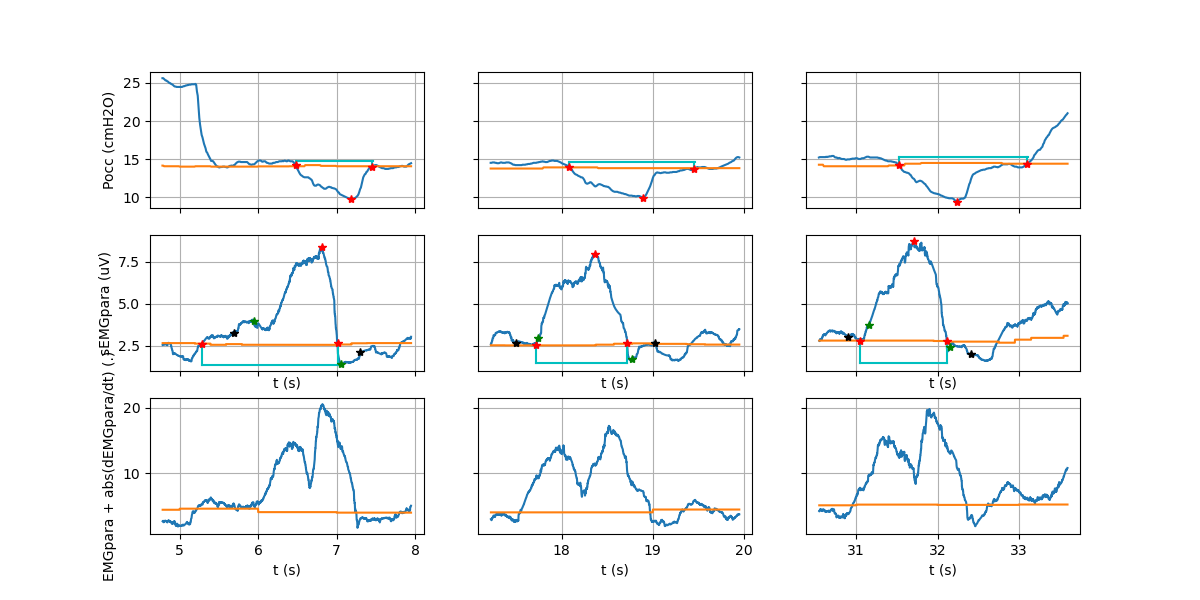

In [633]:
# Plot new baseline crossing detection parasternal
fig_6, axis = plt.subplots(nrows=3, ncols=max([len(
    P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# Show EMG and Paw data for entire window
t_plot_start = np.min([[P_occ_starts / draeger_sample_rate], 
                    [EMG_di_occ_starts_old / emg_sample_rate], 
                    [EMG_para_occ_starts_old / emg_sample_rate]], axis=0)[0] - 0.5
t_plot_end = np.max([[P_occ_ends / draeger_sample_rate], 
                     [EMG_di_occ_ends_old / emg_sample_rate], 
                     [EMG_para_occ_ends_old / emg_sample_rate]], axis=0)[0] + 0.5


# PTP_occ_baseline[idx], ETP_di_baseline[idx], ETP_para_baseline[idx]]
PTP_occs = np.zeros((len(P_occ_peaks),))
P_aw_max = np.zeros((len(P_occ_peaks),))
PTP_occ_baseline = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * draeger_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * draeger_sample_rate), len(y_draeger)])

    axis[0, idx].grid(True)
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1], 
                      x[start_plot_i:end_plot_i+1])
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1],
                      P_rolling_base_line[start_plot_i:end_plot_i+1])    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*draeger_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*draeger_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    axis[0, idx].plot([y_draeger[start_i], y_draeger[end_i+1]], 
                      [P_aw_max[idx], P_aw_max[idx]], 'c')
    axis[0, idx].plot([y_draeger[start_i], y_draeger[start_i]], 
                      [x[start_i], P_aw_max[idx]], 'c')
    axis[0, idx].plot([y_draeger[end_i], y_draeger[end_i]], 
                      [x[end_i], P_aw_max[idx]], 'c')


    axis[0, idx].plot(y_draeger[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(y_draeger[start_i], x[start_i], '*r')
    axis[0, idx].plot(y_draeger[end_i], x[end_i], '*r')

axis[0, 0].set_ylabel('Pocc (cmH2O)')


y_para_min = np.zeros((len(EMG_para_occ_peaks),))
for idx in range(len(EMG_para_occ_peaks)):
    start_i = EMG_para_occ_starts_old[idx]
    end_i = EMG_para_occ_ends_old[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_emg)])
    
    axis[1, idx].grid(True)
    
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1], 
                      y_para[start_plot_i:end_plot_i+1])
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1],
                      emg_para_rolling_base_line[start_plot_i:end_plot_i+1])

    baseline_start_i = max([0, EMG_para_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_para) - 1, EMG_para_occ_peaks[idx] + 5*emg_sample_rate])
    y_para_min[idx] = min(y_para[baseline_start_i:baseline_end_i])

    axis[1, idx].plot([y_emg[start_i], y_emg[end_i+1]], 
                      [y_para_min[idx], y_para_min[idx]], 'c')
    axis[1, idx].plot([y_emg[start_i], y_emg[start_i]], 
                      [y_para[start_i], y_para_min[idx]], 'c')
    axis[1, idx].plot([y_emg[end_i], y_emg[end_i]], 
                      [y_para[end_i], y_para_min[idx]], 'c')

    axis[1, idx].plot(y_emg[EMG_para_occ_peaks[idx]],
                      y_para[EMG_para_occ_peaks[idx]], '*r')
    axis[1, idx].plot(y_emg[start_i], y_para[start_i], '*r')
    axis[1, idx].plot(y_emg[end_i], y_para[end_i], '*r')


    
    axis[1, idx].set_xlabel('t (s)')
    # axis[1, idx].plot(y_emg[start_plot_i:end_plot_i], 
    #                   EMG_para_aug[start_plot_i:end_plot_i], 
    #                   'tab:gray', linewidth=0.5)
    
    axis[2, idx].grid(True)
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i], 
                      EMG_para_aug[start_plot_i:end_plot_i])
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i], 
                      emg_para_aug_rolling_base_line[start_plot_i:end_plot_i])
    axis[2, idx].set_xlabel('t (s)')
    
    axis[1, idx].plot(y_emg[EMG_para_occ_starts[idx]], 
                      y_para[EMG_para_occ_starts[idx]], '*g')
    axis[1, idx].plot(y_emg[EMG_para_occ_ends[idx]], 
                      y_para[EMG_para_occ_ends[idx]], '*g')
    axis[1, idx].plot(y_emg[EMG_para_occ_starts[idx]-ma_window//2], 
                        y_para[EMG_para_occ_starts[idx]-ma_window//2], '*k')
    axis[1, idx].plot(y_emg[EMG_para_occ_ends[idx]+ma_window//2], 
                        y_para[EMG_para_occ_ends[idx]+ma_window//2], '*k')
    
                
axis[1, 0].set_ylabel('sEMGpara (uV)')
axis[2, 0].set_ylabel('EMGpara + abs(dEMGpara/dt) (.)')
EMG_para_occ_starts, EMG_para_occ_starts_old, EMG_para_occ_ends, EMG_para_occ_ends_old



In [634]:
# Determine interpeak distance -> ECG or EMG?
# Determine pneumatic interpeak distance -> Using pressure signal
P_abs_t = np.abs(x - PEEP_set)
treshold = 0.5 * np.percentile(P_abs_t, 90)
prominence = 0.5 * np.percentile(P_abs_t, 90)
width = 0.25 * draeger_sample_rate
resp_efforts, _ = scipy.signal.find_peaks(
    P_abs_t, height=treshold, prominence=prominence, width=width)

t_delta_resp_efforts = np.median(np.array(y_draeger)[resp_efforts[1:]] 
                                 - np.array(y_draeger)[resp_efforts[:-1]])


# Determine pneumatic interpeak distance -> Using volume signal
V_t = x_draeger[2, int(start_draeger_s):int(end_draeger_s)]
treshold = 0.25 * np.percentile(V_t, 90)
prominence = 0.10 * np.percentile(V_t, 90)
width = 0.25 * draeger_sample_rate
resp_efforts_volume_1, _ = scipy.signal.find_peaks(
    V_t, height=treshold, prominence=prominence, width=width)

treshold = 0.5 * np.percentile(V_t[resp_efforts_volume_1], 90)
prominence = 0.5 * np.percentile(V_t, 90)
width = 0.25 * draeger_sample_rate
resp_efforts_volume, _ = scipy.signal.find_peaks(
    V_t, height=treshold, prominence=prominence, width=width)

t_delta_resp_efforts_volume = np.median(
    np.array(y_draeger)[resp_efforts_volume[1:]] 
    - np.array(y_draeger)[resp_efforts_volume[:-1]])

# Determine electrophysiological interpeak distance
t_delta_di_med = np.median(np.array(y_emg)[EMG_peaks_di[1:]] 
                           - np.array(y_emg)[EMG_peaks_di[:-1]])
t_delta_para_med = np.median(np.array(y_emg)[EMG_peaks_para[1:]] 
                             - np.array(y_emg)[EMG_peaks_para[:-1]])
t_delta_ecg_med = np.median(np.array(y_emg)[ECG_peaks[1:]] 
                            - np.array(y_emg)[ECG_peaks[:-1]])


# t_delta_resp_efforts, t_delta_di_med, t_delta_para_med, t_delta_ecg_med
t_delta_resp_efforts, t_delta_resp_efforts_volume

(2.960000000000001, 3.030000000000001)

(0.0, 10.46798576442968)

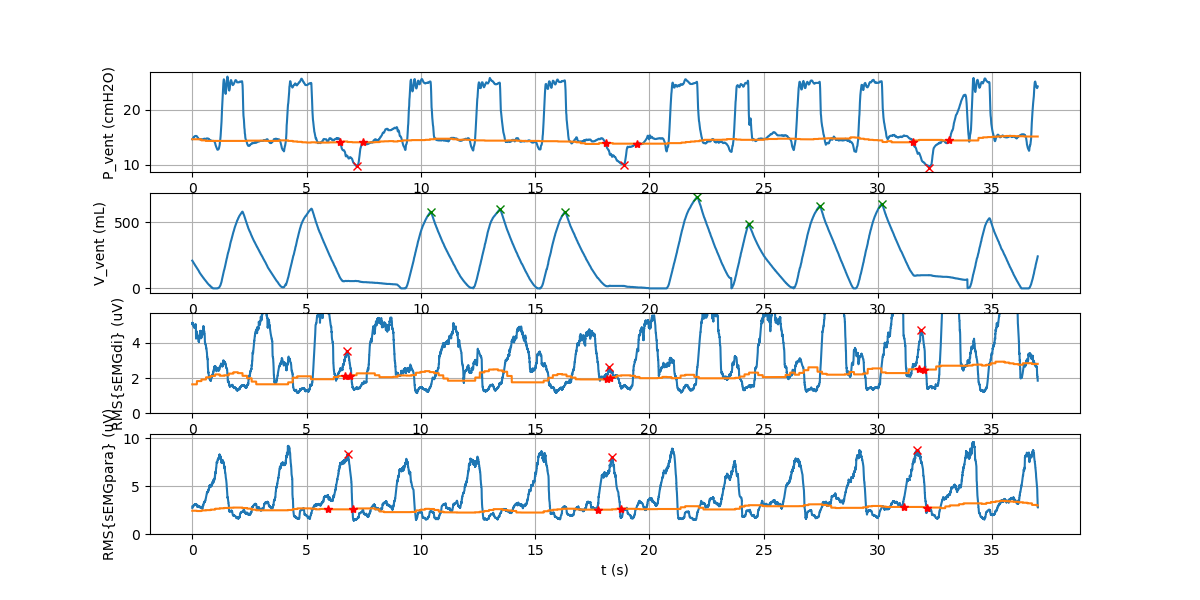

In [635]:
# Plot entire selected time window with indicated peaks
# P_vent
fig_1, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
axis[0].grid(True)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))], x)
axis[0].plot([y / draeger_sample_rate for y in range(len(x))],
             P_rolling_base_line)
axis[0].plot(P_occ_peaks/draeger_sample_rate, x[P_occ_peaks], "x", color="r")
axis[0].plot(P_occ_starts / draeger_sample_rate,
             P_rolling_base_line[P_occ_starts], '*r')
axis[0].plot(P_occ_ends / draeger_sample_rate,
             P_rolling_base_line[P_occ_ends], '*r')
axis[0].set_ylabel('P_vent (cmH2O)')

# V_vent
x_vent = x_draeger[2, int(start_draeger_s):int(end_draeger_s)]
axis[1].grid(True)
axis[1].plot([y / draeger_sample_rate for y in range(len(x))], x_vent)
axis[1].set_ylabel('V_vent (mL)')

double_dips = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    if idx > 0 :
        intermediate_breaths = np.equal(
            (P_occ_peaks[idx-1] < resp_efforts_volume  ), 
            (resp_efforts_volume < P_occ_peaks[idx]))
        
        if len(intermediate_breaths[intermediate_breaths == True]) > 0:
            double_dips[idx] = False
        else:
            double_dips[idx] = True

        axis[1].plot(
            resp_efforts_volume[intermediate_breaths]/draeger_sample_rate, 
            x_vent[resp_efforts_volume[intermediate_breaths]], "x", color="g")

    else:
        double_dips[idx] = False

# sEMGdi:
axis[2].grid(True)
N_samp = len(RMS_data_emg_di[int(start_s):int(end_s)])
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_di[int(start_s):int(end_s)])
axis[2].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_di_rolling_base_line[:int(end_s)-int(start_s)])
axis[2].plot(EMG_di_occ_peaks/emg_sample_rate,
             y_di[EMG_di_occ_peaks], "x", color="r")
axis[2].plot(EMG_di_occ_starts / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_starts], '*r')
axis[2].plot(EMG_di_occ_ends / emg_sample_rate,
             emg_di_rolling_base_line[EMG_di_occ_ends], '*r')
axis[2].set_ylabel('RMS{sEMGdi} (uV)')
axis[2].set_xlabel('t (s)')
axis[2].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])

# sEMGopara
axis[3].grid(True)
axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
             RMS_data_emg_para[int(start_s):int(end_s)])
axis[3].plot(EMG_para_occ_peaks/emg_sample_rate,
             y_para[EMG_para_occ_peaks], "x", color="r")

axis[3].plot([y / emg_sample_rate for y in range(N_samp)],
             emg_para_rolling_base_line[:int(end_s)-int(start_s)])
axis[3].plot(EMG_para_occ_starts / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_starts], '*r')
axis[3].plot(EMG_para_occ_ends / emg_sample_rate,
             emg_para_rolling_base_line[EMG_para_occ_ends], '*r')
axis[3].set_ylabel('RMS{sEMGpara} (uV)')
axis[3].set_xlabel('t (s)')
axis[3].set_ylim([0, 1.2*max(y_para[EMG_para_occ_peaks])])

(array([3.05752954, 3.63910584, 4.50336149]),
 array([0.44094152, 0.14162555, 0.72299292]),
 array([4.82157614, 4.26666509, 4.91416641]),
 array([ 6.93409303, 25.69526445,  6.22877673]),
 array([1.66627888, 1.32018188, 1.9053357 ]),
 array([3.25998205, 3.14707352, 3.09489612]))

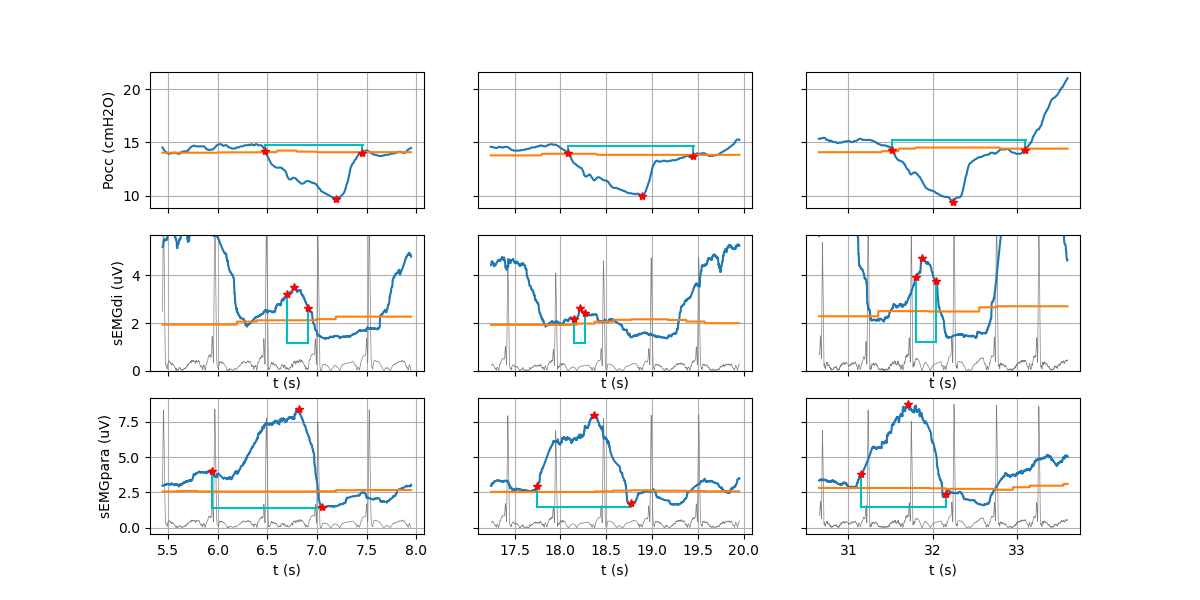

In [636]:
# Subplot per indicated peak
fig_2, axis = plt.subplots(nrows=3, ncols=max([len(
    P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# Show EMG and Paw data for entire window
t_plot_start = np.min([[P_occ_starts / draeger_sample_rate], 
                    [EMG_di_occ_starts / emg_sample_rate], 
                    [EMG_para_occ_starts / emg_sample_rate]], axis=0)[0] - 0.5
t_plot_end = np.max([[P_occ_ends / draeger_sample_rate], 
                     [EMG_di_occ_ends / emg_sample_rate], 
                     [EMG_para_occ_ends / emg_sample_rate]], axis=0)[0] + 0.5


# PTP_occ_baseline[idx], ETP_di_baseline[idx], ETP_para_baseline[idx]]
PTP_occs = np.zeros((len(P_occ_peaks),))
P_peak_occs = np.zeros((len(P_occ_peaks),))
P_aw_max = np.zeros((len(P_occ_peaks),))
PTP_occ_baseline = np.zeros((len(P_occ_peaks),))
PTP_occs_peak = np.zeros((len(P_occ_peaks),))
PTP_occ_peak_baseline = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * draeger_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * draeger_sample_rate), len(x)-1])

    axis[0, idx].grid(True)
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1], 
                      x[start_plot_i:end_plot_i+1])
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1],
                      P_rolling_base_line[start_plot_i:end_plot_i+1])    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*draeger_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*draeger_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    axis[0, idx].plot([y_draeger[start_i], y_draeger[end_i+1]], 
                      [P_aw_max[idx], P_aw_max[idx]], 'c')
    axis[0, idx].plot([y_draeger[start_i], y_draeger[start_i]], 
                      [x[start_i], P_aw_max[idx]], 'c')
    axis[0, idx].plot([y_draeger[end_i], y_draeger[end_i]], 
                      [x[end_i], P_aw_max[idx]], 'c')

    P_peak_occs[idx] = x[   [idx]]

    PTP_occ_baseline[idx] = np.trapz(
        P_aw_max[idx] - P_rolling_base_line[start_i:end_i+1],
        dx=1/draeger_sample_rate
    )

    PTP_occ_peak_baseline[idx] = np.trapz(
        P_aw_max[idx] - P_rolling_base_line[start_i:P_occ_peaks[idx]+1],
        dx=1/draeger_sample_rate
    )


    axis[0, idx].plot(y_draeger[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(y_draeger[start_i], x[start_i], '*r')
    axis[0, idx].plot(y_draeger[end_i], x[end_i], '*r')

    # Pressure Time Product (ETP) occlusion
    PTP_occs[idx] = np.abs(np.trapz(
        x[start_i:end_i+1]-P_rolling_base_line[start_i:end_i+1],
        dx=1/draeger_sample_rate
    )) + PTP_occ_baseline[idx]

    PTP_occs_peak[idx] = np.abs(np.trapz(
        x[start_i:P_occ_peaks[idx]+1]
        - P_rolling_base_line[start_i:P_occ_peaks[idx]+1],
        dx=1/draeger_sample_rate
    )) + PTP_occ_peak_baseline[idx]

axis[0, 0].set_ylabel('Pocc (cmH2O)')

ETP_di_occs = np.zeros((len(EMG_di_occ_peaks),))
y_di_min = np.zeros((len(EMG_di_occ_peaks),))
ETP_di_baseline = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts[idx]
    end_i = EMG_di_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_di)-1])
    
    axis[1, idx].grid(True)
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i], 
                      ecg_rms[start_plot_i+205:end_plot_i+205]/
                      max(ecg_rms[start_plot_i+205:end_plot_i+205])*
                      max(y_di[start_plot_i:end_i]), 
                      'tab:gray', linewidth=0.5)
    
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1], 
                      y_di[start_plot_i:end_plot_i+1])
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1],
                      emg_di_rolling_base_line[start_plot_i:end_plot_i+1])

    baseline_start_i = max([0, EMG_di_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di) - 1, EMG_di_occ_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di[baseline_start_i:baseline_end_i])

    axis[1, idx].plot([y_emg[start_i], y_emg[end_i+1]], 
                      [y_di_min[idx], y_di_min[idx]], 'c')
    axis[1, idx].plot([y_emg[start_i], y_emg[start_i]], 
                      [y_di[start_i], y_di_min[idx]], 'c')
    axis[1, idx].plot([y_emg[end_i], y_emg[end_i]], 
                      [y_di[end_i], y_di_min[idx]], 'c')

    ETP_di_baseline[idx] = np.trapz(
        emg_di_rolling_base_line[start_i:end_i+1] - y_di_min[idx],
        dx=1/emg_sample_rate
    )

    axis[1, idx].plot(y_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[1, idx].plot(y_emg[start_i], y_di[start_i], '*r')
    axis[1, idx].plot(y_emg[end_i], y_di[end_i], '*r')


    
    axis[1, idx].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])

    # EMG Time Product (ETP) diaphragm
    ETP_di_occs[idx] = np.trapz(
        y_di[start_i:end_i+1] - emg_di_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    ) + ETP_di_baseline[idx]

    axis[1, idx].set_xlabel('t (s)')

axis[1, 0].set_ylabel('sEMGdi (uV)')

ETP_para_occs = np.zeros((len(EMG_para_occ_peaks),))
y_para_min = np.zeros((len(EMG_para_occ_peaks),))
ETP_para_baseline = np.zeros((len(EMG_para_occ_peaks),))
for idx in range(len(EMG_para_occ_peaks)):
    start_i = EMG_para_occ_starts[idx]
    end_i = EMG_para_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_para)-1])

    axis[2, idx].grid(True)
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i], 
                    ecg_rms[start_plot_i+205:end_plot_i+205]/
                    max(ecg_rms[start_plot_i+205:end_plot_i+205])*
                    max(y_para[start_plot_i:end_plot_i]), 
                    'tab:gray', linewidth=0.5)
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i+1], 
                      y_para[start_plot_i:end_plot_i+1])
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i+1],
                      emg_para_rolling_base_line[start_plot_i:end_plot_i+1])
    
    baseline_start_i = max([0, EMG_para_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_para) - 1, EMG_para_occ_peaks[idx] + 5*emg_sample_rate])
    y_para_min[idx] = min(y_para[baseline_start_i:baseline_end_i])

    axis[2, idx].plot([y_emg[start_i], y_emg[end_i+1]], 
                      [y_para_min[idx], y_para_min[idx]], 'c')
    axis[2, idx].plot([y_emg[start_i], y_emg[start_i]], 
                      [y_para[start_i], y_para_min[idx]], 'c')
    axis[2, idx].plot([y_emg[end_i], y_emg[end_i]], 
                      [y_para[end_i], y_para_min[idx]], 'c')

    ETP_para_baseline[idx] = np.trapz(
        emg_para_rolling_base_line[start_i:end_i+1] - y_para_min[idx],
        dx=1/emg_sample_rate
    )

    axis[2, idx].plot(y_emg[EMG_para_occ_peaks[idx]],
                      y_para[EMG_para_occ_peaks[idx]], '*r')
    axis[2, idx].plot(y_emg[start_i], y_para[start_i], '*r')
    axis[2, idx].plot(y_emg[end_i], y_para[end_i], '*r')

    # EMG Time Product (ETP) parasternal
    ETP_para_occs[idx] = np.trapz(
        y_para[start_i:end_i+1] - emg_para_rolling_base_line[start_i:end_i+1],
        dx=1/emg_sample_rate
    ) + ETP_para_baseline[idx]

    axis[2, idx].set_xlabel('t (s)')

axis[2, 0].set_ylabel('sEMGpara (uV)')


# Calculated neuromuscular efficiency: NME = PTP / ETP_di
NME_di = np.abs(PTP_occs)/ETP_di_occs

SNR_di = hf.snr_pseudo(
    src_signal=RMS_data_emg_di[int(start_s):int(end_s)], 
    peaks=EMG_di_occ_peaks, 
    baseline=emg_di_rolling_base_line[:int(end_s)-int(start_s)]\
)
SNR_para = hf.snr_pseudo(
    src_signal=RMS_data_emg_para[int(start_s):int(end_s)], 
    peaks=EMG_para_occ_peaks, 
    baseline=emg_para_rolling_base_line[:int(end_s)-int(start_s)]    
)


PTP_occs, ETP_di_occs, ETP_para_occs, NME_di, SNR_di, SNR_para

Text(0, 0.5, 'Sample count (.)')

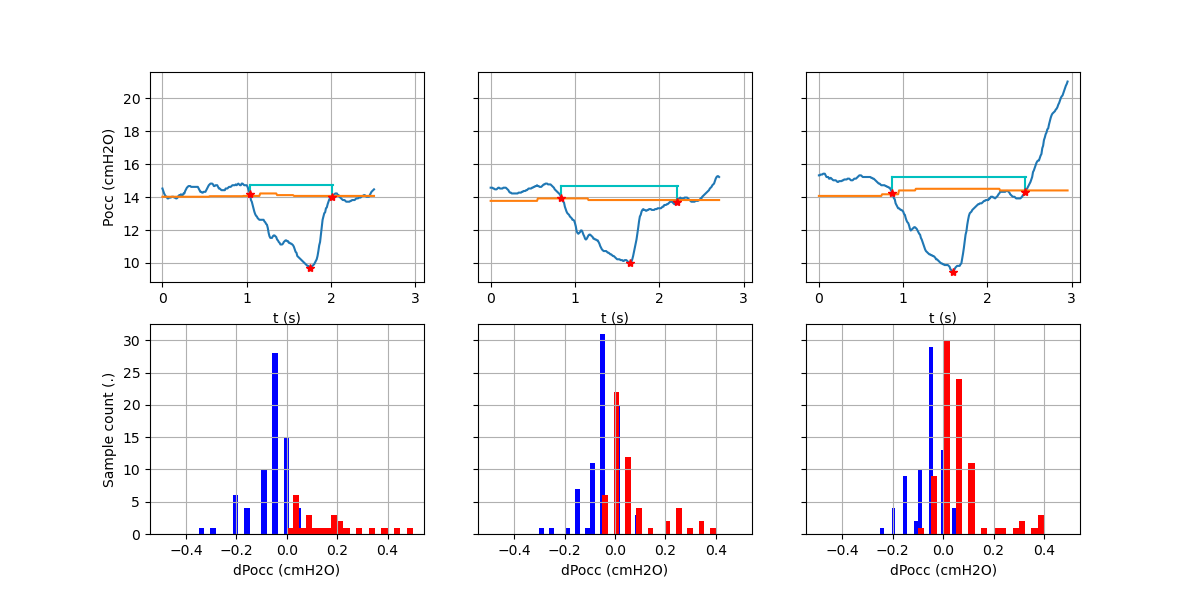

In [637]:
# dPocc in up and downslope comparison for early release detection

fig_4, axis_tmp = plt.subplots(nrows=2, ncols=max([len(
    P_occ_peaks),2]), figsize=(12, 6), sharex='row', sharey='row')

y_draeger = np.array(y_draeger)

n_bins = 20
# PTP_occs
dP_up_10 = np.zeros((len(P_occ_peaks),))
dP_up_90 = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):

    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * draeger_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * draeger_sample_rate), len(x)-1])
    
    # P_vent-time plots
    axis_tmp[0, idx].grid(True)
    axis_tmp[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1] - y_draeger[start_plot_i], 
                      x[start_plot_i:end_plot_i+1])
    axis_tmp[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1]- y_draeger[start_plot_i],
                      P_rolling_base_line[start_plot_i:end_plot_i+1])    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*draeger_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*draeger_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    axis_tmp[0, idx].plot([y_draeger[start_i], y_draeger[end_i+1]] - y_draeger[start_plot_i], 
                      [P_aw_max[idx], P_aw_max[idx]], 'c')
    axis_tmp[0, idx].plot([y_draeger[start_i], y_draeger[start_i]] - y_draeger[start_plot_i], 
                      [x[start_i], P_aw_max[idx]], 'c')
    axis_tmp[0, idx].plot([y_draeger[end_i], y_draeger[end_i]] - y_draeger[start_plot_i], 
                      [x[end_i], P_aw_max[idx]], 'c')

    axis_tmp[0, idx].plot(y_draeger[P_occ_peaks[idx]] - y_draeger[start_plot_i],
                    x[P_occ_peaks[idx]], '*r')
    axis_tmp[0, idx].plot(y_draeger[start_i] - y_draeger[start_plot_i],
                      x[start_i], '*r')
    axis_tmp[0, idx].plot(y_draeger[end_i] - y_draeger[start_plot_i], 
                      x[end_i], '*r')
    axis_tmp[0, idx].set_xlabel('t (s)')

    dP_up_10[idx] = np.percentile(
        x[P_occ_peaks[idx]+1:end_i]-x[P_occ_peaks[idx]:end_i-1], 10)
    dP_up_90[idx] = np.percentile(
        x[P_occ_peaks[idx]+1:end_i]-x[P_occ_peaks[idx]:end_i-1], 90)
    
    # Histogram of dPocc/dx in down- (blue) and upslope (red)
    axis_tmp[1, idx].grid(True)
    axis_tmp[1, idx].hist(
        x[start_i+1:P_occ_peaks[idx]+1]-x[start_i:P_occ_peaks[idx]], 
        bins=n_bins, color='b')

    axis_tmp[1, idx].grid(True)
    axis_tmp[1, idx].hist(
        x[P_occ_peaks[idx]+1:end_i]-x[P_occ_peaks[idx]:end_i-1], 
        bins=n_bins, color='r')

    axis_tmp[1, idx].set_xlabel('dPocc (cmH2O)')

# Make x-axes symmetric in y-axis
low, high = axis_tmp[1, 0].get_xlim()
bound = max(abs(low), abs(high))
axis_tmp[1, 0].set_xlim(-bound, bound)
axis_tmp[0, 0].set_ylabel('Pocc (cmH2O)')
axis_tmp[1, 0].set_ylabel('Sample count (.)')


Text(0, 0.5, 'sEMGpara (uV)')

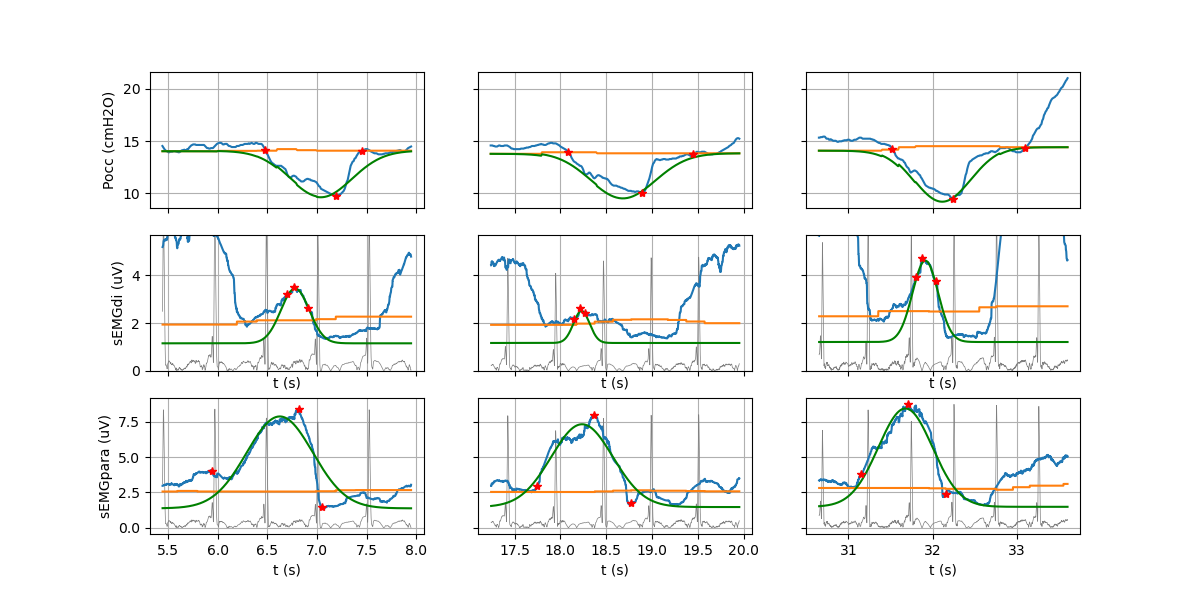

In [638]:
# Fit to bell plots
fig_3, axis = plt.subplots(nrows=3, ncols=max([len(
    P_occ_peaks), 2]), figsize=(12, 6), sharex='col', sharey='row')

# Show EMG and Paw data for entire window
t_plot_start = np.min([[P_occ_starts / draeger_sample_rate], 
                    [EMG_di_occ_starts / emg_sample_rate], 
                    [EMG_para_occ_starts / emg_sample_rate]], axis=0)[0] - 0.5
t_plot_end = np.max([[P_occ_ends / draeger_sample_rate], 
                     [EMG_di_occ_ends / emg_sample_rate], 
                     [EMG_para_occ_ends / emg_sample_rate]], axis=0)[0] + 0.5

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-(x-b)**2 / c**2)

# PTP_occ_baseline[idx], ETP_di_baseline[idx], ETP_para_baseline[idx]]
PTP_occ_bell_error = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * draeger_sample_rate), 0])
    end_plot_i = min(
        [int(t_plot_end[idx] * draeger_sample_rate), len(x)-1])

    axis[0, idx].grid(True)
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1], 
                      x[start_plot_i:end_plot_i+1])
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1],
                      P_rolling_base_line[start_plot_i:end_plot_i+1])
    

    baseline_start_i = max([0, P_occ_peaks[idx] - 5*draeger_sample_rate])
    baseline_end_i = min([len(x) - 1, P_occ_peaks[idx] + 5*draeger_sample_rate])
    P_aw_max[idx] = max(P_rolling_base_line[baseline_start_i:baseline_end_i])

    popt, pcov = curve_fit(func, 
                        y_draeger[start_i:end_i+1], 
                        -(x[start_i:end_i+1]-P_aw_max[idx]),
                        bounds=([0., y_draeger[P_occ_peaks[idx]]-0.5, 0.], 
                                [100., y_draeger[P_occ_peaks[idx]]+0.5, 0.5])
                        )
    
    PTP_occ_bell_error[idx] = np.trapz(
        np.sqrt((x[start_i:end_i+1] - 
        (-func(y_draeger[start_i:end_i+1], *popt)+P_aw_max[idx])) **2),
        dx=1/draeger_sample_rate
    )
    axis[0, idx].plot(y_draeger[start_plot_i:end_plot_i+1], 
                    -func(y_draeger[start_plot_i:end_plot_i+1], *popt)
                    + P_rolling_base_line[start_plot_i:end_plot_i+1], 'g')

    axis[0, idx].plot(y_draeger[P_occ_peaks[idx]], x[P_occ_peaks[idx]], '*r')
    axis[0, idx].plot(y_draeger[start_i], x[start_i], '*r')
    axis[0, idx].plot(y_draeger[end_i], x[end_i], '*r')


axis[0, 0].set_ylabel('Pocc (cmH2O)')

ETP_di_bell_error = np.zeros((len(EMG_di_occ_peaks),))
for idx in range(len(EMG_di_occ_peaks)):
    start_i = EMG_di_occ_starts[idx]
    end_i = EMG_di_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_di)-1])
    
    axis[1, idx].grid(True)
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i], 
                      ecg_rms[start_plot_i+205:end_plot_i+205]/
                      max(ecg_rms[start_plot_i+205:end_plot_i+205])*
                      max(y_di[start_plot_i:end_i]), 
                      'tab:gray', linewidth=0.5)
    
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1], 
                      y_di[start_plot_i:end_plot_i+1])
    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1],
                      emg_di_rolling_base_line[start_plot_i:end_plot_i+1])
    
    baseline_start_i = max([0, EMG_di_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_di) - 1, EMG_di_occ_peaks[idx] + 5*emg_sample_rate])
    y_di_min[idx] = min(y_di[baseline_start_i:baseline_end_i])

    popt, pcov = curve_fit(func, 
                    y_emg[start_i:end_i+1], 
                    y_di[start_i:end_i+1]-y_di_min[idx],
                    bounds=([0., y_emg[EMG_di_occ_peaks[idx]]-0.5, 0.], 
                            [60., y_emg[EMG_di_occ_peaks[idx]]+0.5, 0.5])
                    )

    ETP_di_bell_error[idx] = np.trapz(
        np.sqrt((y_di[start_i:end_i+1] - 
        (func(y_emg[start_i:end_i+1], *popt)+y_di_min[idx])) **2),
        dx=1/emg_sample_rate
    )

    axis[1, idx].plot(y_emg[start_plot_i:end_plot_i+1], 
                      func(y_emg[start_plot_i:end_plot_i+1], *popt)
                      + y_di_min[idx], 'g')
    


    axis[1, idx].plot(y_emg[EMG_di_occ_peaks[idx]],
                      y_di[EMG_di_occ_peaks[idx]], '*r')
    axis[1, idx].plot(y_emg[start_i], y_di[start_i], '*r')
    axis[1, idx].plot(y_emg[end_i], y_di[end_i], '*r')

    axis[1, idx].set_ylim([0, 1.2*max(y_di[EMG_di_occ_peaks])])

    axis[1, idx].set_xlabel('t (s)')

axis[1, 0].set_ylabel('sEMGdi (uV)')

ETP_para_bell_error = np.zeros((len(EMG_para_occ_peaks),))
for idx in range(len(EMG_para_occ_peaks)):
    start_i = EMG_para_occ_starts[idx]
    end_i = EMG_para_occ_ends[idx]
    start_plot_i = max([int(t_plot_start[idx] * emg_sample_rate), 0])
    end_plot_i = min([int(t_plot_end[idx] * emg_sample_rate), len(y_para)-1])

    axis[2, idx].grid(True)
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i], 
                    ecg_rms[start_plot_i+205:end_plot_i+205]/
                    max(ecg_rms[start_plot_i+205:end_plot_i+205])*
                    max(y_para[start_plot_i:end_plot_i]), 
                    'tab:gray', linewidth=0.5)
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i+1], 
                      y_para[start_plot_i:end_plot_i+1])
    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i+1],
                      emg_para_rolling_base_line[start_plot_i:end_plot_i+1])
    baseline_start_i = max([0, EMG_para_occ_peaks[idx] - 5*emg_sample_rate])
    baseline_end_i = min(
        [len(y_para) - 1, EMG_para_occ_peaks[idx] + 5*emg_sample_rate])
    y_para_min[idx] = min(y_para[baseline_start_i:baseline_end_i])

    popt, pcov = curve_fit(func, 
                        y_emg[start_i:end_i+1], 
                        y_para[start_i:end_i+1]-y_para_min[idx],
                        bounds=([0., y_emg[EMG_para_occ_peaks[idx]]-0.5, 0.], 
                                [60., y_emg[EMG_para_occ_peaks[idx]]+0.5, 0.5])
                        )
    
    ETP_para_bell_error[idx] = np.trapz(
        np.sqrt((y_para[start_i:end_i+1] - 
        (func(y_emg[start_i:end_i+1], *popt)+y_para_min[idx])) **2),
        dx=1/emg_sample_rate
    )

    axis[2, idx].plot(y_emg[start_plot_i:end_plot_i+1], 
                      func(y_emg[start_plot_i:end_plot_i+1], *popt)
                      +y_para_min[idx], 'g')

    axis[2, idx].plot(y_emg[EMG_para_occ_peaks[idx]],
                      y_para[EMG_para_occ_peaks[idx]], '*r')
    axis[2, idx].plot(y_emg[start_i], y_para[start_i], '*r')
    axis[2, idx].plot(y_emg[end_i], y_para[end_i], '*r')

    

    axis[2, idx].set_xlabel('t (s)')

axis[2, 0].set_ylabel('sEMGpara (uV)')


# Store values for later analysis

In [639]:
fig_1.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx] 
              + '/' + measurements[date_idx] + '_' + patient + '_' 
              + measurement + '_timeplots_'+str(int(gate_width*1000))+'.png', 
              dpi=300)
fig_2.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  
              + '/' + measurements[date_idx] + '_' + patient + '_'
              + measurement + '_snapshots_'+str(int(gate_width*1000))+'.png', 
              dpi=300)
fig_3.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  
              + '/' + measurements[date_idx] + '_' + patient + '_' 
              + measurement + '_bell_errors_'+str(int(gate_width*1000))+'.png', 
              dpi=300)

fig_4.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  
              + '/' + measurements[date_idx] + '_' + patient + '_' 
              + measurement + '_Pocc_slopes_'+str(int(gate_width*1000))+'.png', 
              dpi=300)

fig_5.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  
              + '/' + measurements[date_idx] + '_' + patient + '_' 
              + measurement + '_baseline_detection_di_'+str(int(gate_width*1000))+'.png', 
              dpi=300)
fig_6.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  
              + '/' + measurements[date_idx] + '_' + patient + '_' 
              + measurement + '_baseline_detection_para_'+str(int(gate_width*1000))+'.png', 
              dpi=300)

In [640]:
try:
    df
except NameError:
    df_exists = False
else:
    df_exists = True

if len(big_data_list) == 0 or (df_exists and not (measurement in df['measurement'].to_list())):
    print('Data of measurement ' + measurement + ' not yet added to the ' 
        + 'dataframe. Adding the data of:')
    patient, measurements[date_idx], measurement

    
    for idx in range(len(PTP_occs)):
        data_now = [patient, measurement, PEEP_set, PTP_occs[idx],
                    ETP_di_occs[idx], NME_di[idx], ETP_para_occs[idx], 
                    SNR_di[idx], SNR_para[idx], 
                    PTP_occ_baseline[idx], ETP_di_baseline[idx], 
                    ETP_para_baseline[idx],
                    PTP_occ_bell_error[idx], ETP_di_bell_error[idx], 
                    ETP_para_bell_error[idx], 
                    P_peak_occs[idx], PTP_occs_peak[idx], 
                    PTP_occ_peak_baseline[idx], 
                    t_delta_resp_efforts, t_delta_resp_efforts_volume, 
                    t_delta_di_med, t_delta_para_med, t_delta_ecg_med,
                    P_occ_peaks[idx]/draeger_sample_rate, 
                    P_occ_starts[idx]/draeger_sample_rate, 
                    P_occ_ends[idx]/draeger_sample_rate,
                    EMG_di_occ_peaks[idx]/emg_sample_rate, 
                    EMG_di_occ_starts[idx]/emg_sample_rate, 
                    EMG_di_occ_ends[idx]/emg_sample_rate,
                    EMG_para_occ_peaks[idx]/emg_sample_rate, 
                    EMG_para_occ_starts[idx]/emg_sample_rate, 
                    EMG_para_occ_ends[idx]/emg_sample_rate,
                    dP_up_10[idx], dP_up_90[idx], double_dips[idx],
                    ]
        
        big_data_list.append(data_now)
else:
    print('Data of PEEP step ' + measurement + ' already added to the ' 
          + 'dataframe. Don''t add the data twice!')
    


Data of measurement 009 not yet added to the dataframe. Adding the data of:


In [641]:
# del big_data_list[-3:]
# del big_data_list[7:]

# big_data_list = list(df.values)

big_data_list

[['MST010',
  '006',
  7.0,
  2.606423413753509,
  0.16583028713121686,
  15.717414827190881,
  3.3363644219799684,
  1.1976632963658718,
  2.6529711943586336,
  0.40610494852066037,
  0.10415867232674414,
  0.8162684480583003,
  0.31908681248011944,
  0.0035355722588218006,
  0.6141740321356908,
  4.120999813079834,
  2.1825634288787845,
  0.3063339400291444,
  3.4949999999999997,
  3.060000000000002,
  1.20703125,
  1.70947265625,
  0.583984375,
  6.09,
  5.25,
  6.3,
  5.466796875,
  5.31103515625,
  5.54541015625,
  5.46533203125,
  4.7041015625,
  5.91748046875,
  0.04999971389770508,
  0.30009984970092773,
  0.0],
 ['MST010',
  '006',
  7.0,
  2.8472178792953495,
  0.47931290390541126,
  5.940207025716183,
  3.3962522931106474,
  1.55251767362759,
  2.676399117061371,
  1.098520839214325,
  0.24844896783971876,
  0.9521785260830055,
  0.5266896028300743,
  0.02601979430775834,
  0.6506183805827641,
  4.221099853515625,
  2.2975794029235845,
  0.9284698510169986,
  3.4949999999999

In [642]:
columns_now = ['patient', 'measurement', 'PEEP_set', 'PTP_occs', 'ETP_di_occs', 
               'NME_di', 'ETP_para_occs', 'SNR_di', 'SNR_para',
               'PTP_occ_baseline', 'ETP_di_baseline', 'ETP_para_baseline', 
               'PTP_occ_bell_SE', 'ETP_di_bell_SE', 'ETP_para_bell_SE', 
               'P_peak_occs', 'PTP_occs_peak', 'PTP_occ_peak_baseline', 
               't_delta_resp_efforts', 't_delta_resp_efforts_volume', 
               't_delta_di_med', 't_delta_para_med', 't_delta_ecg_med',
               't_Pocc_peak', 't_Pocc_start', 't_Pocc_end',
               't_di_peak', 't_di_start', 't_di_end',
               't_para_peak', 't_para_start', 't_para_end',
               'dP_up_10', 'dP_up_90', 'double_dip'
               ]

df = pd.DataFrame(big_data_list, columns=columns_now)
df

,patient,measurement,PEEP_set,PTP_occs,ETP_di_occs,NME_di,ETP_para_occs,SNR_di,SNR_para,PTP_occ_baseline,...,t_Pocc_end,t_di_peak,t_di_start,t_di_end,t_para_peak,t_para_start,t_para_end,dP_up_10,dP_up_90,double_dip
0,MST010,006,7.0,2.606423,0.165830,15.717415,3.336364,1.197663,2.652971,0.406105,...,6.30,5.466797,5.311035,5.545410,5.465332,4.704102,5.917480,0.05000,0.30010,0.0
1,MST010,006,7.0,2.847218,0.479313,5.940207,3.396252,1.552518,2.676399,1.098521,...,9.60,8.946289,8.889648,9.257324,9.095703,8.241211,9.344727,-0.02500,0.35010,0.0
2,MST010,006,7.0,3.280004,0.284024,11.548325,3.286320,1.196496,2.596563,0.507590,...,15.90,14.947266,14.747070,15.027832,14.948242,14.335938,15.378906,-0.01500,0.28010,0.0
3,MST010,006,7.0,3.058468,0.226233,13.519134,3.071789,1.378862,2.542892,0.333250,...,29.84,29.175293,29.113770,29.290527,29.195801,28.586914,29.404297,0.05000,0.35010,0.0
4,MST010,007,9.0,3.358309,0.727482,4.616346,4.985505,1.111150,2.851061,0.493348,...,4.91,4.286621,4.044922,4.718262,4.168457,3.844238,4.604004,0.00000,0.60014,0.0
5,MST010,007,9.0,3.270323,10.393604,0.314648,4.920192,1.319842,2.755890,0.235094,...,10.03,9.066406,7.478516,9.292969,9.358398,8.877930,9.729004,0.13010,0.66016,0.0
6,MST010,007,9.0,4.120785,10.487541,0.392922,5.013189,4.513008,2.653087,0.749708,...,23.73,21.986816,21.005371,22.480957,23.034180,22.467285,23.398438,0.09002,0.60012,0.0
7,MST010,008,11.0,4.425876,16.438960,0.269231,5.543919,1.744581,2.591762,0.280574,...,7.58,6.758301,5.151367,6.906250,6.882324,6.250488,7.142578,0.00000,0.61011,0.0
8,MST010,008,11.0,6.596625,0.926757,7.117963,5.292234,1.476038,3.070658,2.158199,...,22.13,21.072754,20.913574,21.551758,20.991211,20.448242,21.331055,-0.05000,0.45017,0.0
9,MST010,008,11.0,6.593211,0.311041,21.197225,5.430966,1.405449,2.544200,1.874831,...,34.90,33.654297,33.588379,33.706543,33.703613,33.186035,34.067871,0.00000,0.49511,0.0


Text(0.5, 1.0, '')

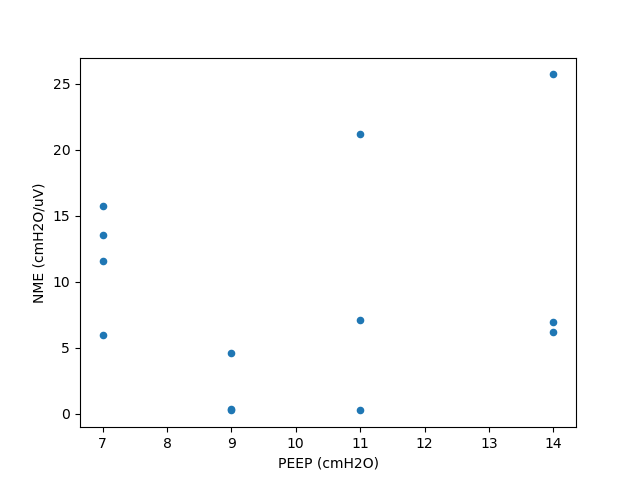

In [643]:
bp = df.plot.scatter('PEEP_set', 'NME_di')
bp.set_ylabel('NME (cmH2O/uV)')
bp.set_xlabel('PEEP (cmH2O)')
bp.set_title('')

In [644]:
# Generate read-me file
if gate_twice == True:
    N_gated = 2
else:
    N_gated = 1

context = (patient + ' / ' + measurements[date_idx] + ' / ' + measurement + '\n'
        +'t_start: ' + str(start) + ' s' + '\n'
        +'t_end: ' + str(end) + ' s' + '\n'
        +'gate_width: ' + str(int(gate_width*1000)) + ' ms' + '\n'
        +'gate_threshold: ' + str(peak_fraction) + '' + '\n'
        +'gate_ECG_shift: ' + str(ECG_shift) + ' samples' + '\n'
        +'time_shift: ' + str(draeger_delay) + ' s' + '\n'
        +'Pocc_prominence_factor: ' + str(Pocc_prominence_factor) 
        + '' + '\n'
        +'EMG_di_prominence_factor: ' + str(EMG_di_prominence_factor) 
        + '' + '\n'
        +'EMG_para_prominence_factor: ' + str(EMG_para_prominence_factor) 
        + '' + '\n'
        +'PEEP_set: ' + str(PEEP_set) + '' + '\n' \
        +'N_gated: ' + str(N_gated) + '' + '\n' \
        +'augmented_percentile: ' + str(augmented_perc) + ' %' + '\n'
        +'analysis_date: ' + str(datetime.now()) + ''
        )

with open(main_output_dir + '/' + patient + '/' + measurements[date_idx] + '/' 
          + measurements[date_idx] + '_' + patient + '_' + measurement 
          + '_readme.txt', 'w') as f:
    f.write(context)

print(context)

MST010 / 2022-04-25_09-36-15 / 009
t_start: 320.0 s
t_end: 357.0 s
gate_width: 100 ms
gate_threshold: 0.3
gate_ECG_shift: -10 samples
time_shift: 0.5 s
Pocc_prominence_factor: 0.15
EMG_di_prominence_factor: 0.01
EMG_para_prominence_factor: 0.5
PEEP_set: 14.0
N_gated: 1
augmented_percentile: 25 %
analysis_date: 2023-09-20 09:24:31.636373


In [645]:
# Move on to the next measurement
if measurement in df['measurement'].to_list():
    if measurement_idx >= len(list_of_numbers_strung):
        print('Data of measurement ' + measurement + ' added to the dataframe. '
              + 'You can continue to the saving the overall data!')
    elif measurement != list_of_numbers_strung[measurement_idx]:
        print('Data of measurement ' + measurement + ' added to the dataframe. '
              + 'You can continue to the next PEEP step!')
    else:
        measurement_idx += 1
        if measurement_idx >= len(list_of_numbers_strung):
            print('Data of measurement ' + measurement + ' added to the '
                + 'dataframe. You can continue to the saving the overall data!')
        else:
            print('Data of measurement ' + measurement + ' added to the '
                + 'dataframe. You can continue to the next PEEP step!')
else:
    print('Data of measurement ' + measurement + ' not yet added to the ' 
        + 'dataframe!')

Data of measurement 009 added to the dataframe. You can continue to the saving the overall data!


['To next PEEP step'](#section_peep_step)

In [646]:
# Store session data if complete
if len(set(df['PEEP_set'].values)) < 4:
    print('Warning: Not 4 PEEP settings evaluated yet!')
else:
    
    df.to_csv(main_output_dir + '/' + patient + '/' + measurements[date_idx]  
              + '/' + measurements[date_idx] + '_' + patient
              +'_NME_output_gate_'+str(int(gate_width*1000)) + '.csv')

    bp.figure.savefig(main_output_dir + '/' + patient + '/' 
                      + measurements[date_idx]  + '/' + measurements[date_idx] 
                      + '_' + patient + '_gate_'+str(int(gate_width*1000)) 
                      + '_scatter.png', dpi=300)
    
    print('Notification: Data of 4 PEEP settings stored!')
    print(measurements[date_idx])

Notification: Data of 4 PEEP settings stored!
2022-04-25_09-36-15


In [647]:
# Move on to the next measurement date if data saved

if not os.path.exists(main_output_dir + '/' + patient + '/' 
                      + measurements[date_idx]  + '/' + measurements[date_idx] 
                      + '_' + patient + '_NME_output_gate_'
                      + str(int(gate_width*1000))+'.csv'):
    print('Warning: Data not stored! Do not progress to next date!')
elif len(set(df['PEEP_set'].values)) < 4:
    print('Warning: Data not stored! Do not progress to next date!')
else:
    date_idx += 1
    if date_idx < len(measurements):
        print('Notification: Data appropriately stored. '
              +'You may progress to next date!')
    else:
        if patient == patients[patient_idx]:
            patient_idx += 1
            date_idx = 0
        print('Notification: Data appropriately stored. \n'+
              'This was the last measurement of this patient. '
              +'You may progress to next patient!')

Notification: Data appropriately stored. You may progress to next date!


In [648]:
# # # Save data anyway:
# df.to_csv(main_output_dir + '/' + patient + '/' + measurements[date_idx]  + '/' 
#           + measurements[date_idx] + '_' + patient + '_NME_output_gate_'
#           +str(int(gate_width*1000))+'.csv')

# bp.figure.savefig(main_output_dir + '/' + patient + '/' + measurements[date_idx]  
#                   + '/' + measurements[date_idx] + '_' + patient + '_gate_' 
#                   + str(int(gate_width*1000))+'_scatter.png', dpi=300)

In [246]:
# # Move on to the next measurement date
# date_idx += 1

In [247]:
# # Move on to the previous measurement date
# date_idx -= 1

In [248]:
# date_idx

['To next measurement date'](#section_date_step)

In [1268]:
# Move on to the next patient
# patient_idx += 1

In [1269]:
# # Move on to the previous patient
# patient_idx -= 1

['To next patient'](#section_patient_step)

In [1270]:
# gate_twice = True